# Table of Contents

* [Overview](#0)
* [Importing Libraries](#1)
* [Load Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Build Model with Pytorch](#5)
* [Prediction](#7)

In [1]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk==3.8

Defaulting to user installation because normal site-packages is not writeable


<a id="0"></a>
# Overview

In this notebook, we are going to do semantic analysis on hotel reviews from Tripadvisor. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network using tensorflow

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
# Importing Libraries

In [2]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
torch.cuda.is_available()

2023-11-28 15:31:49.424618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 15:31:49.459144: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 15:31:49.460107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 15:31:50.149422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

<a id="1"></a>
# Load Dataset

In [5]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="3"></a>
# Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

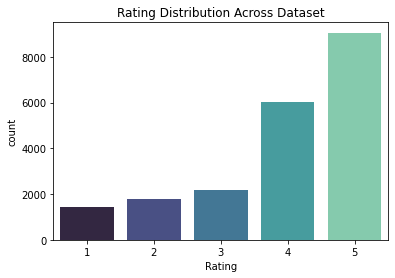

In [7]:
sns.countplot(data=df, x='Rating', palette='mako').set_title('Rating Distribution Across Dataset')

In [8]:
# Length of word in sentence
df['Length'] = df['Review'].apply(lambda r: len(r.split(" ")))
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,89
1,ok nothing special charge diamond member hilto...,2,252
2,nice rooms not 4* experience hotel monaco seat...,3,219
3,"unique, great stay, wonderful time hotel monac...",5,91
4,"great stay great stay, went seahawk game aweso...",5,193


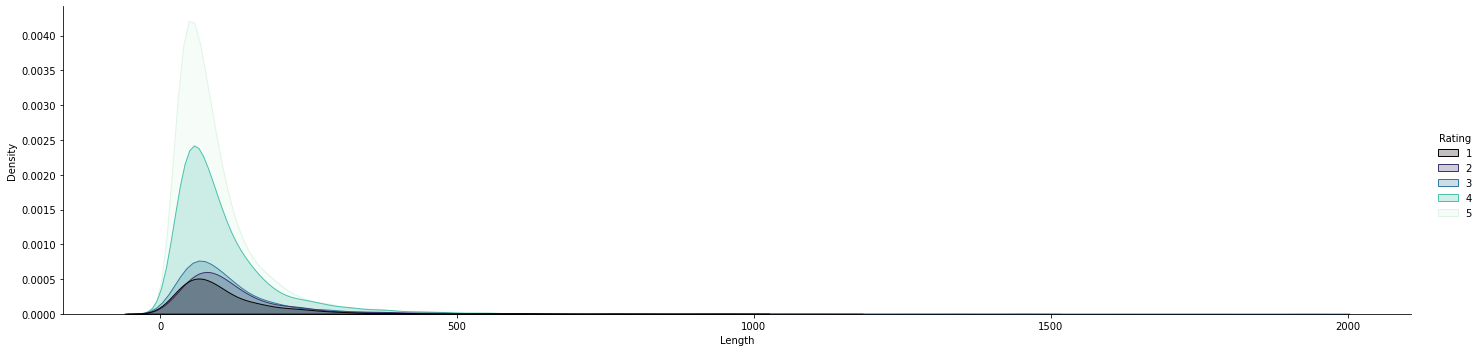

In [9]:
sns.displot(data=df, x='Length', hue='Rating', palette='mako', kind='kde', fill=True, aspect=4)

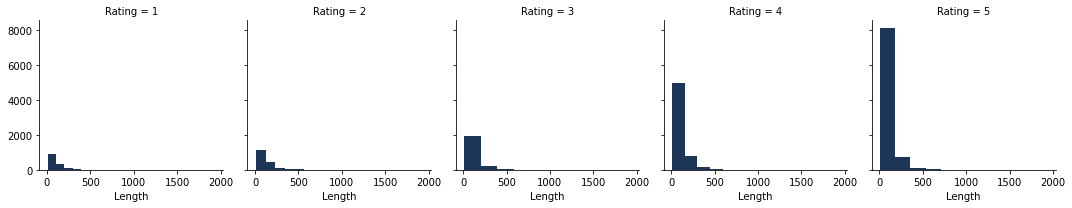

In [10]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#1D3557')

/tmp/ipykernel_33148/836127386.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x='Rating', y='Length', palette='mako', alpha=0.3)


<Axes: xlabel='Rating', ylabel='Length'>

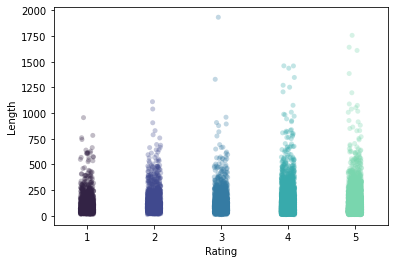

In [11]:
sns.stripplot(data=df, x='Rating', y='Length', palette='mako', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

<a id="4"></a>
# Text Preprocessing

In [12]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 2 # Good
    elif score == 3:
        return 1 # Neutral
    else:
        return 0 # Bad

In [13]:
df['Rating'] = df['Rating'].apply(rating)

In [14]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,2,89
1,ok nothing special charge diamond member hilto...,0,252
2,nice rooms not 4* experience hotel monaco seat...,1,219
3,"unique, great stay, wonderful time hotel monac...",2,91
4,"great stay great stay, went seahawk game aweso...",2,193


# Cleaning and Stemming

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

In [16]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/yash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
df['Review'] = df['Review'].apply(cleaning)

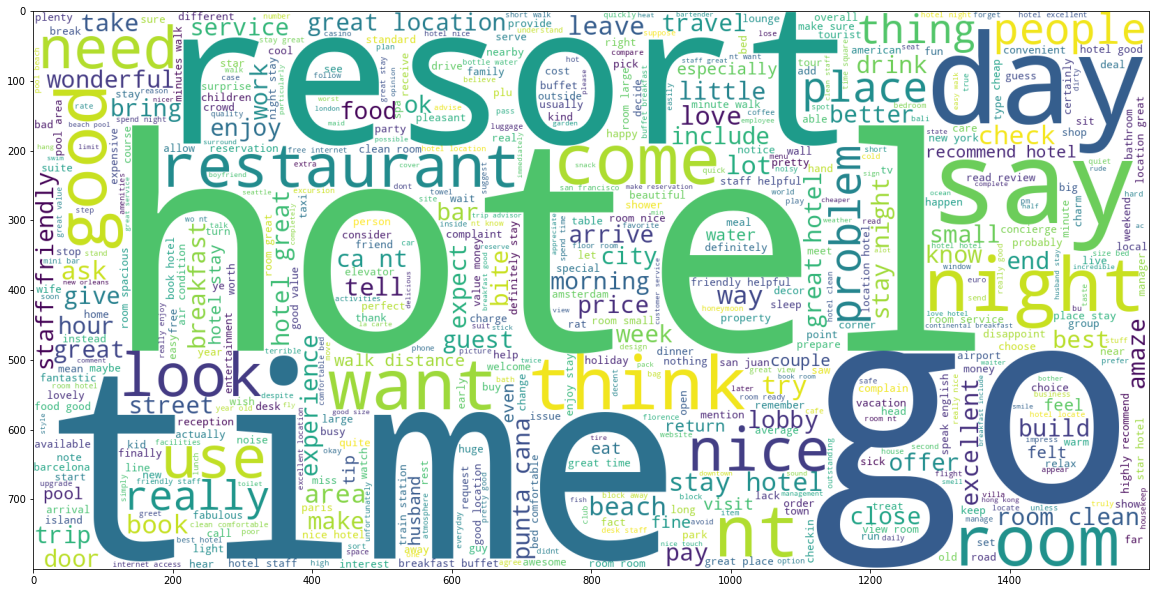

In [20]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(' '.join(df['Review']))

plt.imshow(wc)

In [21]:
df.to_csv("processed_data.csv")

In [22]:
df = pd.read_csv("processed_data.csv")

In [23]:
df.head()

,Unnamed: 0,Review,Rating,Length
0,0,nice hotel expensive park get good deal stay h...,2,89
1,1,ok nothing special charge diamond member hilto...,0,252
2,2,nice room 4 experience hotel monaco seattle go...,1,219
3,3,unique great stay wonderful time hotel monaco ...,2,91
4,4,great stay great stay go seahawk game awesome ...,2,193


In [24]:
# Set a random seed for reproducibility
random_seed = 42

# First, split into training and temporary set (combining validation and test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    df['Review'], df['Rating'], test_size=0.2, random_state=random_seed
)

# Now split the temporary set into validation and test sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=random_seed  # 0.25 x 0.8 = 0.2
)

# building Tokenizer

In [25]:
# build vocabulary, convert text => number
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=80)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=80)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=80)

Total distinct words: 53918


In [26]:
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()

In [27]:
y_train.shape

(12294,)

In [ ]:
import torch.optim.adamw as ada

# BiLSTM

In [28]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

# Optimizer

In [29]:
class adam_w_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.999, lambdaa = 0.01):
        super(adam_w_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.epsilon = epsilon 
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)
                self.state[p]['t'] += 1
                v = self.beta2 * self.state[p]['lr_update'] + (1 - self.beta2) * (p.grad.data)**2
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                self.state[p]['lr_update'] = v
                self.state[p]['momentum'] = m
                m = m / (1 - self.beta1 ** self.state[p]['t'])
                v = v / (1 - self.beta2 ** self.state[p]['t'])
                p.data -= group['lr'] * (m / torch.sqrt(v + self.epsilon) + self.lambdaa * p.data)

# Training Loop

In [30]:
NUM_VOCAB = total_word
EMBED_SIZE = 128
HIDDEN_SIZE = 164
NUM_CLASS = 3
BATCH_SIZE = 32
EPOCHS = 20
LAMBDA = 0.01
betas = (np.arange(0.8, 1.01, 0.01))

lion_learningRate_ablation_train_accuracy = {}
lion_learningRate_ablation_valid_accuracy = {}

num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
inds = np.arange(num_train)
inds_valid = np.arange(num_valid)

# Define your optimizer
loss_func = torch.nn.CrossEntropyLoss()

# Helper function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred.data, 1)
    total = y_true.size(0)
    correct = (predicted == y_true).sum().item()
    return correct / total

for beta1 in betas:
    lion_learningRate_ablation_train_accuracy[beta1] = []
    lion_learningRate_ablation_valid_accuracy[beta1] = []
    model = SentimentAnalysis(total_word=NUM_VOCAB, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_class=NUM_CLASS)
    model = model.to("cuda")
    optimizer = adam_w_optimizer(model.parameters(), learning_rate=0.0001, beta1 = beta1, beta2 = 0.99, lambdaa=0.009)
    BATCH_SIZE = 128
    EPOCH = 20
    print("")
    print(beta1)
    
    for e in range(EPOCH):
        model.train()
        total = 0
        correct = 0
        pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
        for i in pbar:
            x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
            x = x.type(dtype=torch.IntTensor).to("cuda")
            y_hat = model(x)
            y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
            y = y.type(dtype=torch.LongTensor).to("cuda")
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Update progress bar
            train_accuracy = 100 * correct / total
            pbar.set_description("Epoch: {} - Loss: {:.4f} - Acc: {:.2f}%".format(e + 1, loss.item(), train_accuracy))
        
        lion_learningRate_ablation_train_accuracy[beta1].append(100 * correct / total)

        # Validation Accuracy Calculation
        model.eval()
        with torch.no_grad():
            pbar = tqdm(range(0, X_valid.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
            correct  = 0
            total = 0
            for i in pbar:
                x = torch.Tensor(X_valid[inds_valid[i:i+BATCH_SIZE]])
                x = x.type(dtype=torch.IntTensor).to("cuda")
                y_hat = model(x)
                y = torch.Tensor(y_valid[inds_valid[i:i+BATCH_SIZE]])
                y = y.type(dtype=torch.LongTensor).to("cuda")

                # Calculate accuracy
                _, predicted = torch.max(y_hat.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            # Update progress bar
            valid_accuracy = 100 * correct / total
            
            lion_learningRate_ablation_valid_accuracy[beta1].append(valid_accuracy)
            
            print("Validation Accuracy : ",valid_accuracy)
                
           


0.8


Epoch: 1 - Loss: 0.9116 - Acc: 63.55%:  71%|███████   | 69/97 [00:46<00:02, 10.28it/s] 

# Saving Results

In [ ]:
import json

# Save the dictionary to a file
with open('adamW_weightDecay_beta1_ablation_train_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('adamW_weightDecay_beta1_ablation_valid_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_valid_accuracy, file)


# Training Loop

In [ ]:
NUM_VOCAB = total_word
EMBED_SIZE = 128
HIDDEN_SIZE = 164
NUM_CLASS = 3
BATCH_SIZE = 32
EPOCHS = 20
LAMBDA = 0.01
betas = np.concatenate((np.arange(0.9, 0.99, 0.01), np.arange(0.99, 1, 0.001)))

lion_learningRate_ablation_train_accuracy = {}
lion_learningRate_ablation_valid_accuracy = {}

num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
inds = np.arange(num_train)
inds_valid = np.arange(num_valid)

# Define your optimizer
loss_func = torch.nn.CrossEntropyLoss()

# Helper function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred.data, 1)
    total = y_true.size(0)
    correct = (predicted == y_true).sum().item()
    return correct / total

for beta2 in betas:
    lion_learningRate_ablation_train_accuracy[beta2] = []
    lion_learningRate_ablation_valid_accuracy[beta2] = []
    model = SentimentAnalysis(total_word=NUM_VOCAB, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_class=NUM_CLASS)
    model = model.to("cuda")
    optimizer = adam_w_optimizer(model.parameters(), learning_rate=0.0001, beta1 = 0.9, beta2 = beta2, lambdaa=0.009)
    BATCH_SIZE = 128
    EPOCH = 20
    print("")
    print(beta2)
    
    for e in range(EPOCH):
        model.train()
        total = 0
        correct = 0
        pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
        for i in pbar:
            x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
            x = x.type(dtype=torch.IntTensor).to("cuda")
            y_hat = model(x)
            y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
            y = y.type(dtype=torch.LongTensor).to("cuda")
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Update progress bar
            train_accuracy = 100 * correct / total
            pbar.set_description("Epoch: {} - Loss: {:.4f} - Acc: {:.2f}%".format(e + 1, loss.item(), train_accuracy))
        
        lion_learningRate_ablation_train_accuracy[beta2].append(100 * correct / total)

        # Validation Accuracy Calculation
        model.eval()
        with torch.no_grad():
            pbar = tqdm(range(0, X_valid.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
            correct  = 0
            total = 0
            for i in pbar:
                x = torch.Tensor(X_valid[inds_valid[i:i+BATCH_SIZE]])
                x = x.type(dtype=torch.IntTensor).to("cuda")
                y_hat = model(x)
                y = torch.Tensor(y_valid[inds_valid[i:i+BATCH_SIZE]])
                y = y.type(dtype=torch.LongTensor).to("cuda")

                # Calculate accuracy
                _, predicted = torch.max(y_hat.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            # Update progress bar
            valid_accuracy = 100 * correct / total
            
            lion_learningRate_ablation_valid_accuracy[beta2].append(valid_accuracy)
            
            print("Validation Accuracy : ",valid_accuracy)
                
           

# Saving Results

In [ ]:
import json

# Save the dictionary to a file
with open('adamW_weightDecay_beta2_ablation_train_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('adamW_weightDecay_beta2_ablation_valid_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_valid_accuracy, file)
